In [3]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import pymannkendall as mk
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.utils.plotting import plot_series

Importing plotly failed. Interactive plots will not work.


In [4]:
well_data = pd.read_excel('../data/Data-Wells.xlsx')

well_data.head(10)

,Sample ID,Well Name,Entered,"1,4-Dioxane Results (ppb)",Date Sampled,Time Sampled,Date Received,Date Analyzed,Reporting Limit,Reporting Lab,...,Well Comments,Scr Elev Range,bar color,BegFolder KML,EndFolder KML,BegFolder2KML,EndFolder2KML,Max-to-date.1,MaxToDateFlag,Last Date Rd
0,76970,1021 Westview Way,05/10/19,nd,05/08/19,14:05,NaN,05/15/19,1.0,PLS,...,NaN,NaN,green,<Folder><name>1021 Westview Way</name>,</Folder>,<Folder><name>n/a</name>,NaN,0.001,NaN,2019-05-08 00:00:00
1,76971,1024 Westview Way,05/10/19,nd,05/08/19,14:18,NaN,05/15/19,1.0,PLS,...,NaN,NaN,green,<Folder><name>1024 Westview Way</name>,</Folder>,NaN,NaN,0.001,NaN,2019-05-08 00:00:00
2,76969,1049 Westview Way,05/10/19,nd,05/08/19,14:43,NaN,05/14/19,1.0,PLS,...,NaN,NaN,green,<Folder><name>1049 Westview Way</name>,</Folder>,NaN,</Folder>,0.001,NaN,2019-05-08 00:00:00
3,3525,105 Myrtle,NaN,nd,03/27/99,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,<Folder><name>105 Myrtle</name>,NaN,<Folder><name>800-820</name>,NaN,0.001,NaN,2019-04-15 00:00:00
4,3714,105 Myrtle,NaN,nd,05/28/99,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00
5,4013,105 Myrtle,NaN,nd,08/19/99,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00
6,4337,105 Myrtle,NaN,nd,11/16/99,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00
7,4671,105 Myrtle,NaN,nd,02/21/00,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00
8,5428,105 Myrtle,NaN,nd,08/21/00,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00
9,74144,105 Myrtle,06/19/14,nd,06/18/14,12:15,NaN,06/26/14,1.0,PLS,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00


In [5]:
well_data.head(10)

rm_nd = well_data.loc[well_data['1,4-Dioxane Results (ppb)'] != 'nd'].copy()

rm_capital_nd = rm_nd.loc[rm_nd['1,4-Dioxane Results (ppb)'] != 'ND'].copy()

rm_capital_nd['1,4-Dioxane Results (ppb)'] = rm_capital_nd['1,4-Dioxane Results (ppb)'].map(lambda x: x.replace(',', ''))

rm_capital_nd['1,4-Dioxane Results (ppb)'] = rm_capital_nd['1,4-Dioxane Results (ppb)'].map(lambda x: x.replace('<', ''))

res = rm_capital_nd
res.loc[:, 'ds']= pd.to_datetime(res['Date Sampled'])
res.loc[:, 'dioxane_results']= pd.to_numeric(res['1,4-Dioxane Results (ppb)'])
res.head(5)

,Sample ID,Well Name,Entered,"1,4-Dioxane Results (ppb)",Date Sampled,Time Sampled,Date Received,Date Analyzed,Reporting Limit,Reporting Lab,...,bar color,BegFolder KML,EndFolder KML,BegFolder2KML,EndFolder2KML,Max-to-date.1,MaxToDateFlag,Last Date Rd,ds,dioxane_results
16,57,110 Parkland Plaza,NaN,17,08/22/86,NaN,NaN,NaN,1.0,NaN,...,orange,<Folder><name>110 Parkland Plaza</name>,NaN,<Folder><name>840-860</name>,NaN,17.0,MaxToDate,2019-09-12 00:00:00,1986-08-22,17.0
17,58,110 Parkland Plaza,NaN,17,09/19/86,NaN,NaN,NaN,1.0,NaN,...,orange,NaN,NaN,NaN,NaN,17.0,MaxToDate,2019-09-12 00:00:00,1986-09-19,17.0
18,61,110 Parkland Plaza,NaN,12,10/10/86,NaN,NaN,NaN,1.0,NaN,...,orange,NaN,NaN,NaN,NaN,17.0,NaN,2019-09-12 00:00:00,1986-10-10,12.0
19,62,110 Parkland Plaza,NaN,1,10/10/86,NaN,NaN,NaN,1.0,NaN,...,yellow,NaN,NaN,NaN,NaN,17.0,NaN,2019-09-12 00:00:00,1986-10-10,1.0
20,187,110 Parkland Plaza,NaN,7,11/09/87,NaN,NaN,NaN,1.0,NaN,...,orange,NaN,NaN,NaN,NaN,17.0,NaN,2019-09-12 00:00:00,1987-11-09,7.0


In [6]:
di_time = res.iloc[:, lambda df: df.columns.str.contains('Well Name|ds|dioxane_results',
                                              case=False)].copy()
di_time.rename(columns = {'dioxane_results':'y'}, inplace = True)
di_time.head(20)

,Well Name,ds,y
16,110 Parkland Plaza,1986-08-22,17.0
17,110 Parkland Plaza,1986-09-19,17.0
18,110 Parkland Plaza,1986-10-10,12.0
19,110 Parkland Plaza,1986-10-10,1.0
20,110 Parkland Plaza,1987-11-09,7.0
21,110 Parkland Plaza,1987-11-09,18.0
22,110 Parkland Plaza,1988-04-18,13.0
23,110 Parkland Plaza,1988-12-09,14.0
24,110 Parkland Plaza,1989-07-19,11.0
25,110 Parkland Plaza,1990-01-30,12.0


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


18.0
110 Parkland Plaza
             Well Name         ds     y
16  110 Parkland Plaza 1986-08-22  17.0
17  110 Parkland Plaza 1986-09-19  17.0
18  110 Parkland Plaza 1986-10-10  12.0
19  110 Parkland Plaza 1986-10-10   1.0
20  110 Parkland Plaza 1987-11-09   7.0
21  110 Parkland Plaza 1987-11-09  18.0
22  110 Parkland Plaza 1988-04-18  13.0
23  110 Parkland Plaza 1988-12-09  14.0
24  110 Parkland Plaza 1989-07-19  11.0
25  110 Parkland Plaza 1990-01-30  12.0
26  110 Parkland Plaza 1990-08-01   8.0
27  110 Parkland Plaza 1991-01-23  10.0
28  110 Parkland Plaza 1991-08-22  10.0
29  110 Parkland Plaza 1992-07-23   8.0
30  110 Parkland Plaza 1993-03-03   9.0
31  110 Parkland Plaza 1993-08-23   9.0
32  110 Parkland Plaza 1998-12-21   3.0
33  110 Parkland Plaza 1999-08-19   2.0
34  110 Parkland Plaza 1999-11-12   5.0
35  110 Parkland Plaza 2000-02-15   8.0
36  110 Parkland Plaza 2000-08-16   7.0
37  110 Parkland Plaza 2001-01-29   6.0
38  110 Parkland Plaza 2001-05-10   5.0
39  110 Parkland

<Figure size 360x720 with 0 Axes>

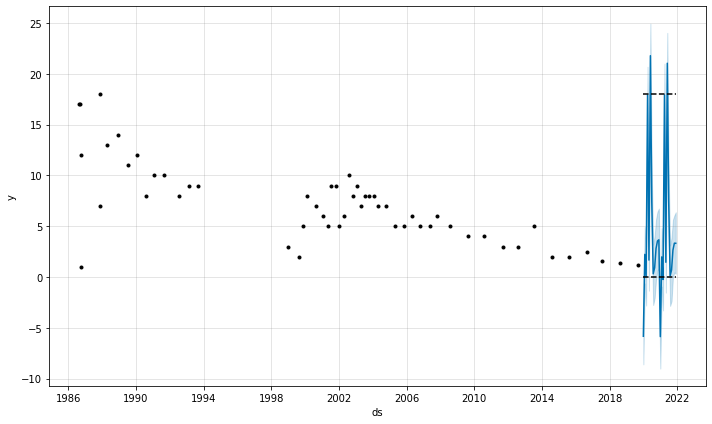

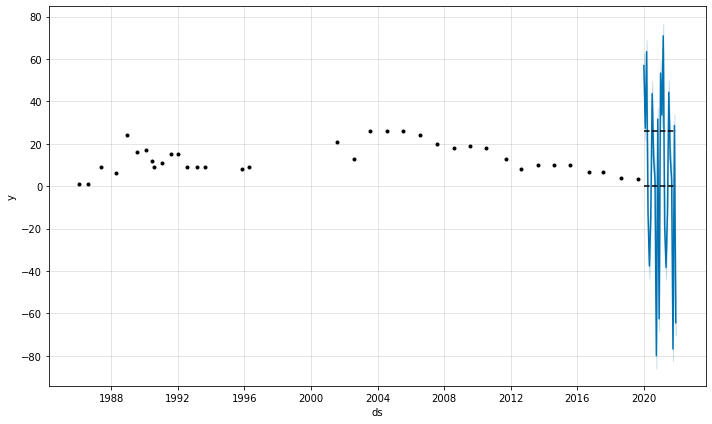

,Well name,trend,h,p,z,Tau,s,var_s,slope,intercept
0,110 Parkland Plaza,decreasing,True,2.326843e-10,-6.338055,-0.591195,-846.0,17774.666667,-0.2,12.3
1,170 Aprill,no trend,False,7.427813e-01,-0.328172,-0.039683,-25.0,5348.333333,0.0,10.5


In [34]:

grouped = di_time.groupby('Well Name')
count = 1
n_rows = 2
n_cols = 1
fig = plt.figure(figsize=(5*n_cols, 5*n_rows))

mk_res = []

for name, group in grouped:
    if count > n_rows:
        break
    if len(group) < 10:
        continue

    max_value = group['y'].max()
    print(max_value)
    print(name)
    print(group)
    test = group

    test['floor'] = 0
    test['cap'] = max_value

    model = Prophet(growth='logistic')
    # fit the model
    model.fit(test)
    # define the period for which we want a prediction
    future = list()
    for y in range(0, 2):
        for i in range(1, 13):
            date = '%04d-%02d' % (2020 + y,  i)
            future.append([date])

    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= pd.to_datetime(future['ds'])
    future['floor'] = 0
    future['cap'] = max_value

    # use the model to make a forecast
    forecast = model.predict(future)
    # summarize the forecast
    print(forecast[['ds', 'yhat']].head())
    # plot forecast
    model.plot(forecast)
    plt.show()

    # ax = fig.add_subplot(n_rows, n_cols, count)
    # ax.plot(test.ds, test.y)
    #  ax.title.set_text(name+'\n')

    # Data generation for analysis
    data = test.y
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(data)

    mk_res.append([name, trend, h, p, z, Tau, s, var_s, slope, intercept])

    count+=1


mk_df = pd.DataFrame(mk_res, columns=['Well name', 'trend', 'h', 'p', 'z', 'Tau', 's', 'var_s','slope' , 'intercept'])
mk_df

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64


pandas.core.series.Series

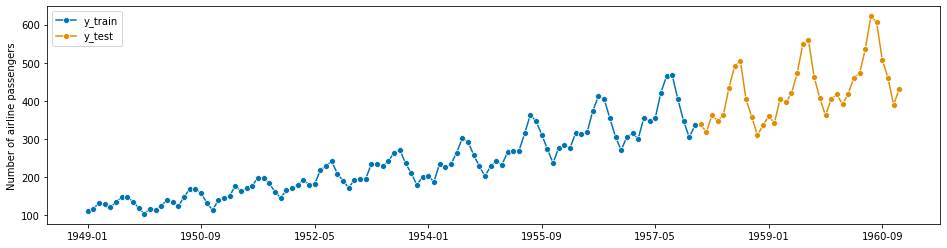

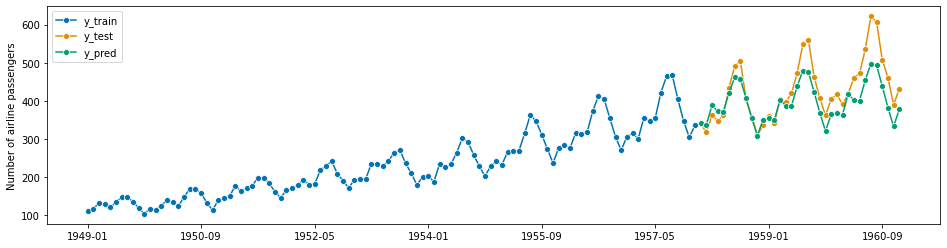

In [8]:

y = load_airline()
print(y)
y_train, y_test = temporal_train_test_split(y)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
type(y)

             Well Name         ds     y
16  110 Parkland Plaza 1986-08-22  17.0
17  110 Parkland Plaza 1986-09-19  17.0
18  110 Parkland Plaza 1986-10-10  12.0
19  110 Parkland Plaza 1986-10-10   1.0
20  110 Parkland Plaza 1987-11-09   7.0
21  110 Parkland Plaza 1987-11-09  18.0
22  110 Parkland Plaza 1988-04-18  13.0
23  110 Parkland Plaza 1988-12-09  14.0
24  110 Parkland Plaza 1989-07-19  11.0
25  110 Parkland Plaza 1990-01-30  12.0
26  110 Parkland Plaza 1990-08-01   8.0
27  110 Parkland Plaza 1991-01-23  10.0
28  110 Parkland Plaza 1991-08-22  10.0
29  110 Parkland Plaza 1992-07-23   8.0
30  110 Parkland Plaza 1993-03-03   9.0
31  110 Parkland Plaza 1993-08-23   9.0
32  110 Parkland Plaza 1998-12-21   3.0
33  110 Parkland Plaza 1999-08-19   2.0
34  110 Parkland Plaza 1999-11-12   5.0
35  110 Parkland Plaza 2000-02-15   8.0
36  110 Parkland Plaza 2000-08-16   7.0
37  110 Parkland Plaza 2001-01-29   6.0
38  110 Parkland Plaza 2001-05-10   5.0
39  110 Parkland Plaza 2001-07-24   9.0


<Figure size 360x720 with 0 Axes>

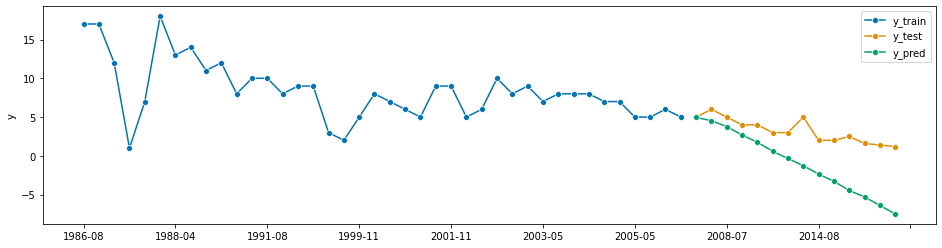

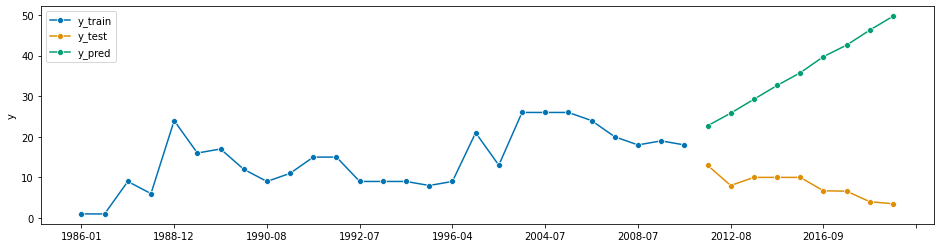

In [9]:
from sktime.forecasting.compose import (
    EnsembleForecaster,
    TransformedTargetForecaster,
    DirectRegressionForecaster,
    ReducedForecaster
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sklearn.neighbors import KNeighborsRegressor
max_value = di_time["y"].max()
# set_index_dt = di_time.set_index(pd.DatetimeIndex(di_time['ds']))

grouped = di_time.groupby('Well Name')
count = 1
n_rows = 2
n_cols = 1
fig = plt.figure(figsize=(5*n_cols, 5*n_rows))

mk_res = []

for name, group in grouped:
    if count > n_rows:
        break
    if len(group) < 10:
        continue

    print(group)
    test = group.set_index('ds')['y'].rename_axis(None)
    test.index = test.index.to_period("M")
    print(test)
    print('test',type(test))
    y_train, y_test = temporal_train_test_split(test)
    print(type(y_test.index))

    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = ThetaForecaster()  # monthly seasonal periodicity
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

    count+=1

In [10]:
a = 1
a


1